In [1]:
import datetime
import os
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


from myutils import wrfread, relativize_snow_values
from dirs import wrfdir, basedir, coorddir, snoteldir

snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]

states = gpd.read_file(f'{basedir}/data/cb_2018_us_state_5m.shp')


/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
def get_line(x,y):
    x = x.values.flatten()
    y = y.values.flatten()
    mask = ~np.isnan(x) | ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y.reshape(-1,1))
    y_pred = model.predict(x.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    return x, y_pred, r2

In [3]:
sweMax = xr.open_dataset(f'{basedir}/data/snowMax.nc').compute().rename({'__xarray_dataarray_variable__': 'swe'})
coordinate_pairs = xr.open_dataset(f'{basedir}/data/site_indices_snow_d02_ALL.nc')
ii = coordinate_pairs['ii_dim'].values.flatten()
jj = coordinate_pairs['jj_dim'].values.flatten()
huc2masks = xr.open_dataset(f'{basedir}/data/huc2_d02_masks.nc')
allcorrs = np.load(f'{basedir}/data/allcorrs_huc2.npy', allow_pickle = True).flatten()[0]

ii_dim = list(coordinate_pairs['ii_dim'].values)
jj_dim = list(coordinate_pairs['jj_dim'].values)
datas = []
for idx in range(703):
    data = sweMax['swe'][:,:,jj[idx], ii[idx]]
    datas.append(data)
snotel_sweMax= xr.concat(datas, dim = 'site')

In [4]:

plt.style.use('style.mplstyle')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{basedir}data/huc2.shp')
huc6 = gpd.read_file(f'{basedir}data/huc6.shp')
hucs_plot = huc2.iloc[[15,18,12,11,9,13]]

coordslist = {}
for d in range(1,5):
    domain = f'd0{d}'
    coord = xr.open_dataset(f'{coorddir}wrfinput_{domain}')
    coordslist[domain] = coord
    

In [5]:
coords = coordslist['d02']
lat = coords['XLAT'][0]
lon = coords['XLONG'][0]

In [7]:
## make some maps of the Upper Colorado and California Basins
all_SDVS = []
allcorrs = {}
for basinnum in range(8):
    mask_bool = masks2['basin_mask'][basinnum].values.astype(bool)
    swe_local_dataset = sweMax.where(mask_bool)
    SDV_all_max = relativize_snow_values(swe_local_dataset)
    all_SDVS.append(SDV_all_max)

In [8]:
y1 = 2006
y2 = 2091
rswe1 = all_SDVS[1].sel(gcm = 0).sel(year = slice(y1-20,y1)).mean(dim = 'year')['relativized_swe']
tswe1 = all_SDVS[1].sel(gcm = 0).sel(year = y1)['swe']
rswe12 = all_SDVS[1].sel(gcm = 0).sel(year = slice(y2-20,y2)).mean(dim = 'year')['relativized_swe']
tswe12 = all_SDVS[1].sel(gcm = 0).sel(year = y1)['swe']
rswe4 = all_SDVS[4].sel(gcm = 0).sel(year = slice(y1-20,y1)).mean(dim = 'year')['relativized_swe']
tswe4 = all_SDVS[4].sel(gcm = 0).sel(year = y1)['swe']
rswe42 = all_SDVS[4].sel(gcm = 0).sel(year = slice(y2-20,y2)).mean(dim = 'year')['relativized_swe']
tswe42 = all_SDVS[4].sel(gcm = 0).sel(year = y2)['swe']

/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/global/homes/c/cowherd/.conda/envs/fos/lib/py

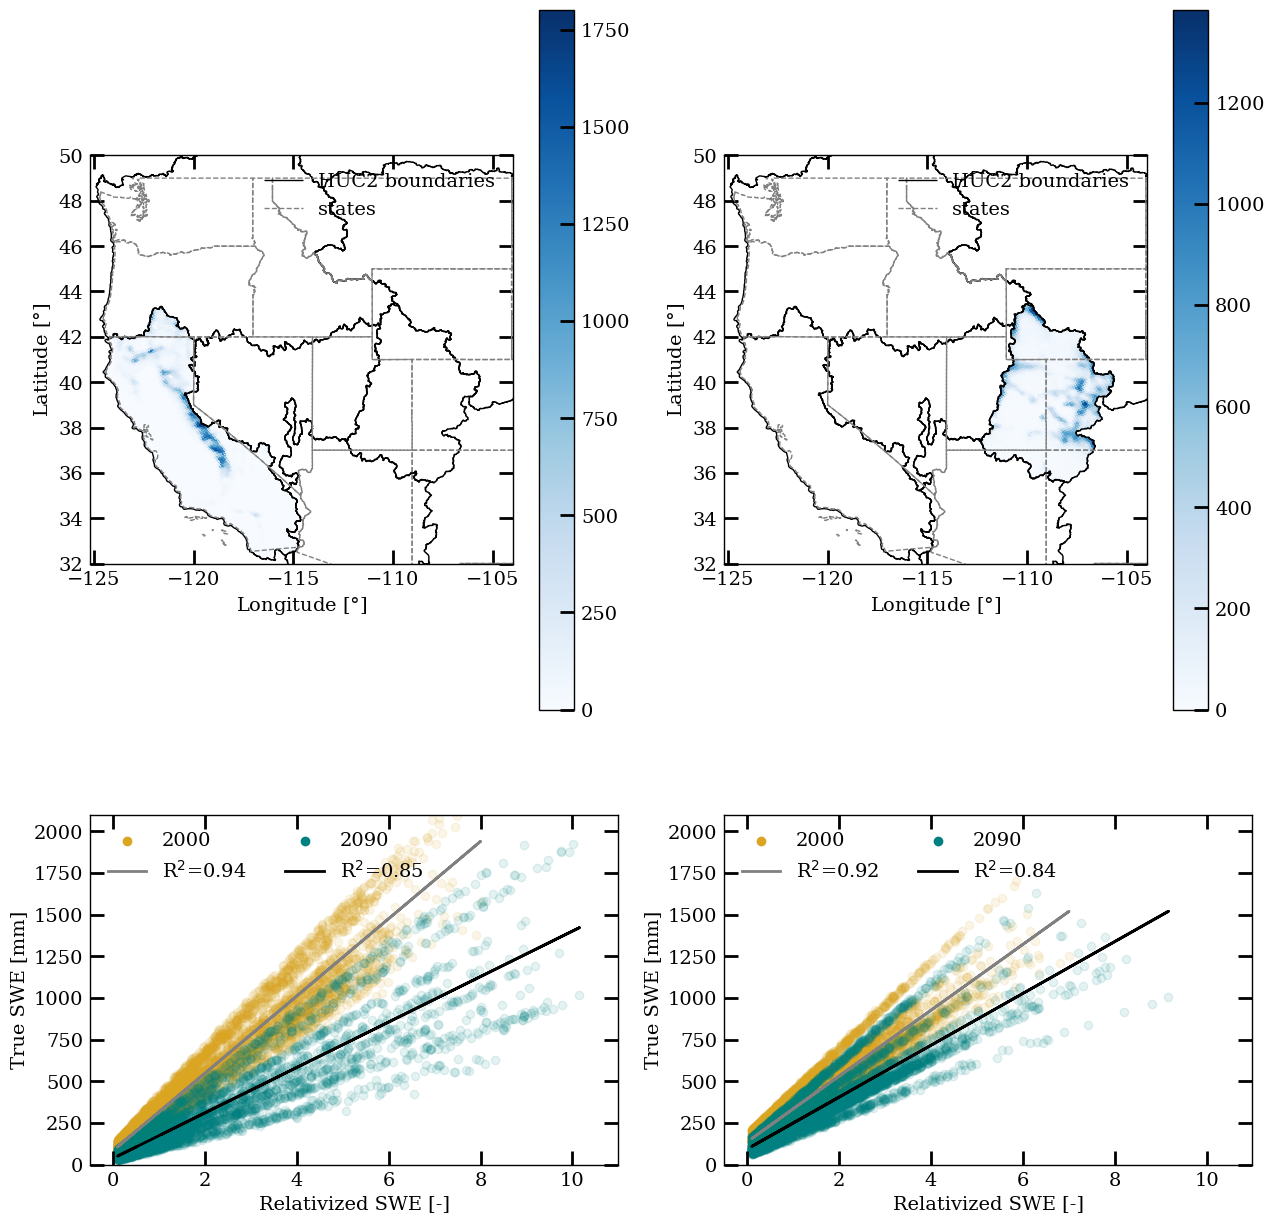

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), gridspec_kw={'height_ratios': [2, 1]})

minval = 10
ys = [2000, 2090]
bs = [4,1] ## california, colorado
ycol = ['goldenrod','teal']
fcol = ['gray','black']

for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        mydata = all_SDVS[bs[j]]
        if i == 0:
            cb = ax.pcolormesh(lon, lat, mydata.sel(year = ys[0]).mean(dim = 'gcm')['swe'], cmap = 'Blues')
            plt.colorbar(cb)
            hucs_plot.boundary.plot(ax = ax, linewidth = 1, label = 'HUC2 boundaries')
            states.boundary.plot(ax=ax, linewidth = 1, linestyle = '--', color = 'gray', label = 'states')
            ax.legend()
            ax.set_ylabel(r'Latitude [$\degree$]')
            ax.set_xlabel(r'Longitude [$\degree$]')
            ax.set_xlim((-125.2,-104))
            ax.set_ylim((32,50))
        else:
            for k,yr in enumerate(ys):
                ydata = mydata.sel(year = slice(yr - 21, yr-1)).mean(dim = 'year')
                ydata = ydata.where(ydata['relativized_swe'] > 0.1)
                swe = ydata['swe']
                ssv = ydata['relativized_swe']
                x,y,r2 = get_line(ssv,swe)
                ax.scatter(ssv, swe, color = ycol[k], alpha = 0.1)
                ax.scatter(np.nanpercentile(ssv, 1),np.nanpercentile(swe, 1), color = ycol[k], alpha = 1, label = yr)
                ax.plot(x,y, color = fcol[k],label = r'R$^{2}$='+"%.2f" % r2)
            ax.set_ylim((0,2100))
            ax.set_xlim((-0.5,11))
            ax.legend(ncol=2, loc = 'upper left')
            ax.set_ylabel('True SWE [mm]')
            ax.set_xlabel('Relativized SWE [-]')


yrs = [2000, 2090]
plt.show()

In [15]:
yrs = [2000, 2090]

for i,b in enumerate(bs):
    mydata = all_SDVS[b]['swe']
    print(labels[i])
    y1s = mydata.sel(year=yrs[0]).mean(dim='gcm').sum().values.flatten()[0]
    y2s = mydata.sel(year=yrs[1]).mean(dim='gcm').sum().values.flatten()[0]
    print(f'{yrs[0]}: {y1s:.2f} mm\n{yrs[1]}: {y2s:.2f} mm\ndiff: {y1s - y2s:.2f} mm\npct: {100 * (y1s - y2s) / y1s:.2f}%')

        

California
2000: 412606.12 mm
2090: 158651.56 mm
diff: 253954.56 mm
pct: 61.55%
Upper Colorado
2000: 497079.81 mm
2090: 257022.80 mm
diff: 240057.02 mm
pct: 48.29%


In [82]:
mydata = all_SDVS[b]#['swe']
all_snows = []
all_r2s = []
all_yrs = []
for gcm in mydata.gcm.values:
    snows_ca = mydata['swe'].sel(gcm=gcm).sum(dim = ['lat2d','lon2d']).values.flatten()
    all_snows.append(snows_ca[21:])
    my_r2 = []
    my_yr = []
    for k, yr in enumerate(mydata.year.values[21:]):
        ssvdata = mydata.sel(year=slice(yr-21, yr-1)).sel(gcm = gcm).mean(dim = 'year')
        #ssvdata = ssvdata.where(ydata['relativized_swe'] > 0)
        swe =  mydata.sel(year=yr).sel(gcm = gcm)['swe']#.where(ydata['relativized_swe'] > 0)['swe']
        ssv = ssvdata['relativized_swe']
        x, y, r2 = get_line(ssv, swe)
        my_r2.append(r2)
        my_yr.append(yr)
    all_r2s.append(my_r2)
    all_yrs.append(my_yr)
all_snows = np.array(all_snows)
all_r2s = np.array(all_r2s)
all_yrs = np.array(all_yrs)

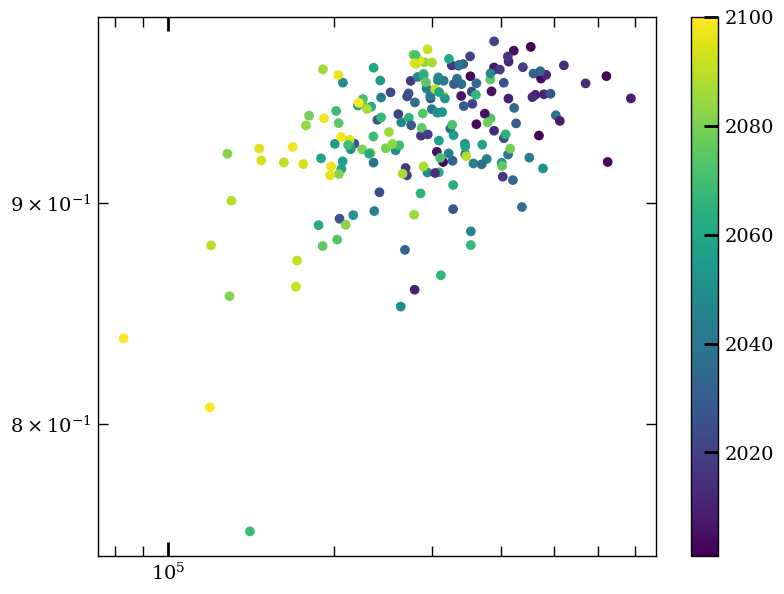

In [96]:
fig, ax = plt.subplots()
for i in range(7,9):
    snows = all_snows[i]
    r2s = all_r2s[i]
    yrs = all_yrs[i]
    cb = ax.scatter(snows, r2s, c=yrs)
    ax.set_yscale('log')
    ax.set_xscale('log')
plt.colorbar(cb)
plt.show()

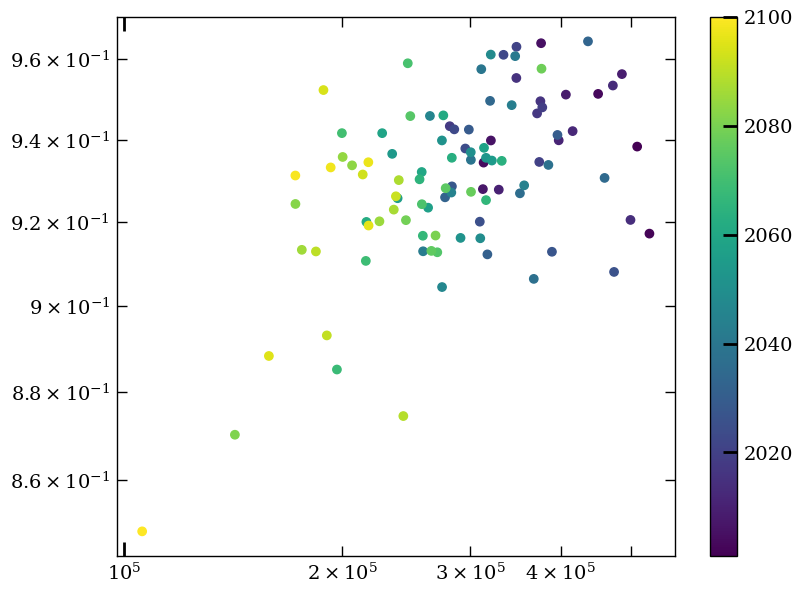

In [98]:
fig, ax = plt.subplots()
snows = np.nanmean(all_snows[6:], axis = 0)
r2s = np.nanmean(all_r2s[6:], axis = 0)
yrs = np.nanmean(all_yrs[6:], axis=0)
cb = ax.scatter(snows, r2s, c=yrs)
ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(cb)
plt.show()

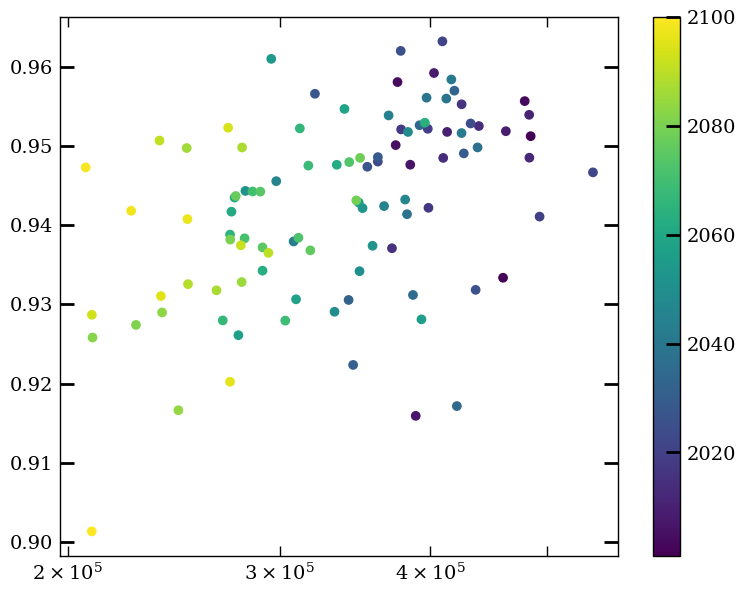

In [104]:
fig, ax = plt.subplots()
snows = np.nanmedian(all_snows, axis = 0)
r2s = np.nanmedian(all_r2s, axis = 0)
yrs = np.nanmedian(all_yrs, axis=0)
cb = ax.scatter(snows, r2s, c=yrs)
#ax.set_yscale('log')
ax.set_xscale('log')
plt.colorbar(cb)
plt.show()

/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


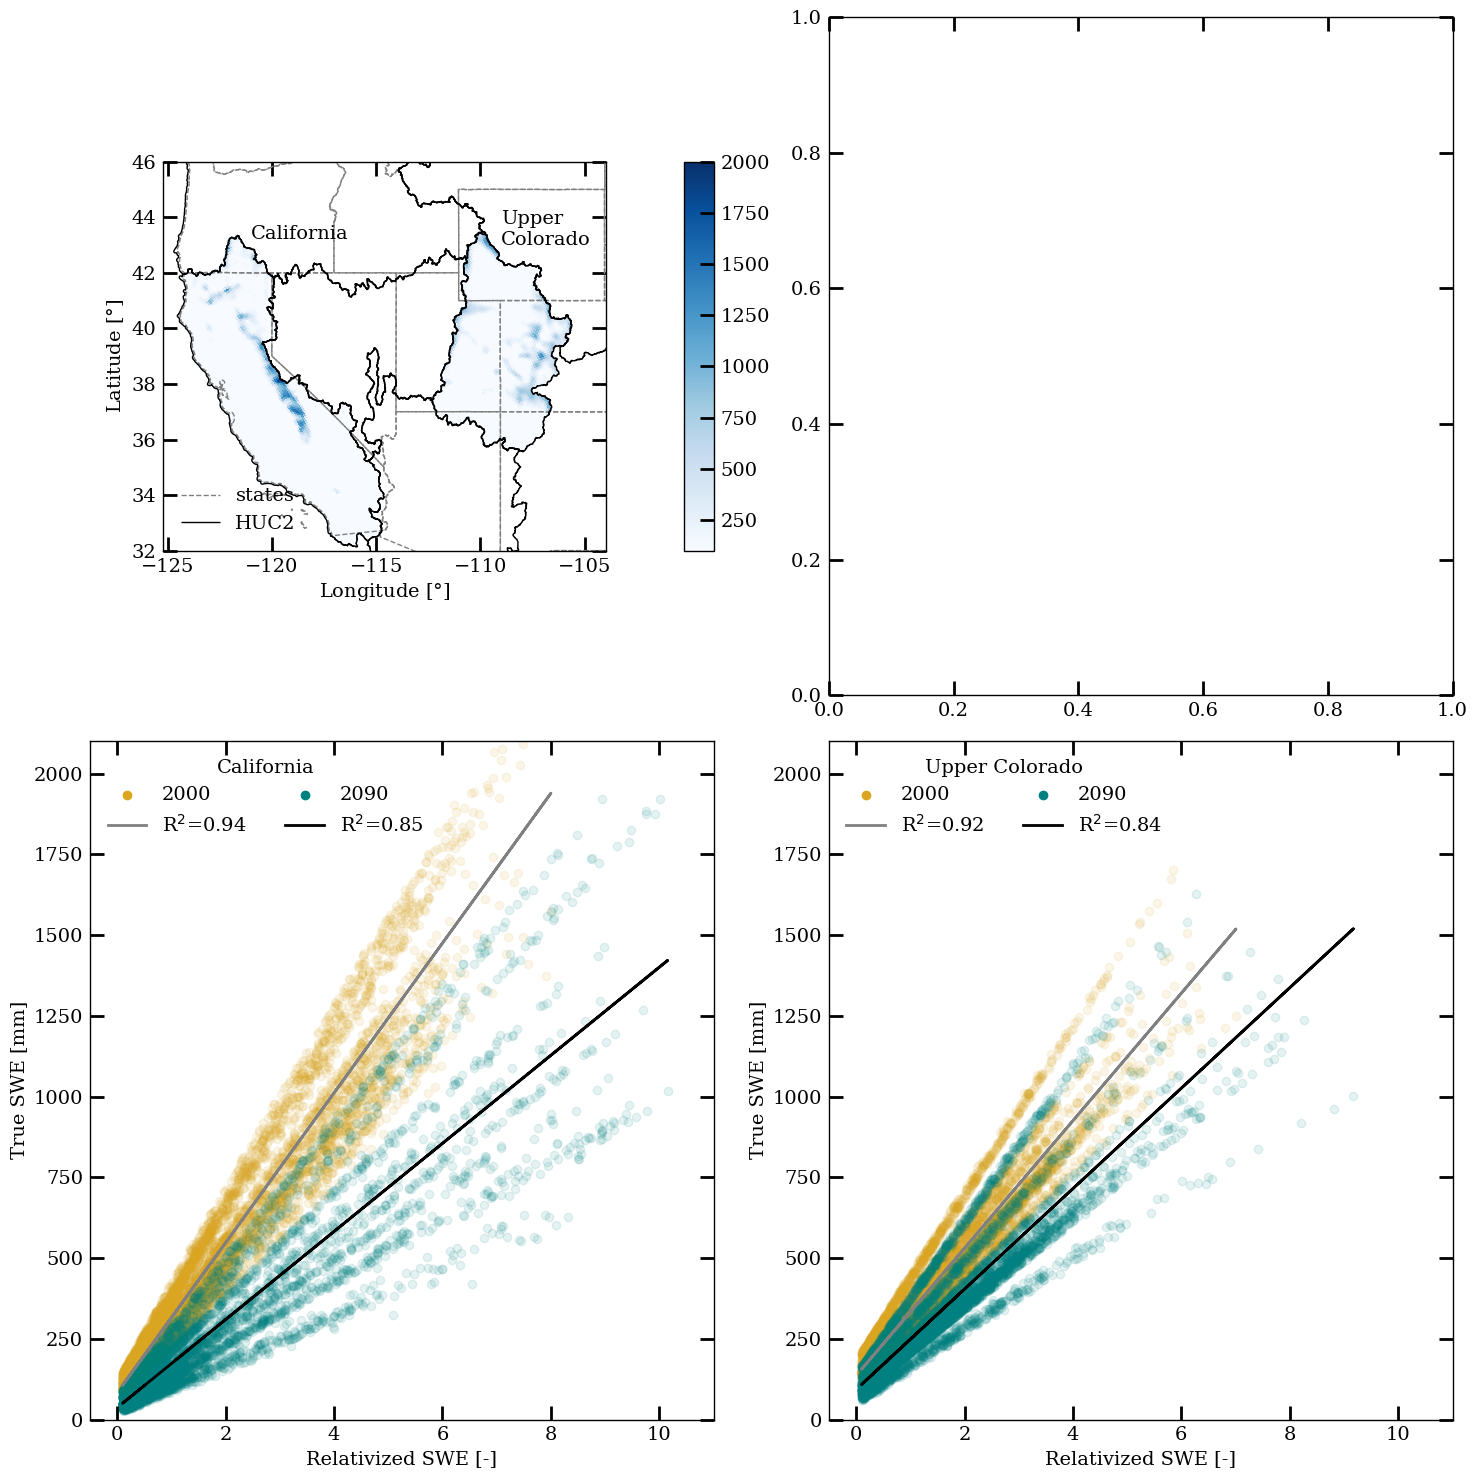

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

minval = 10
yrs = [2000, 2090]
bs = [4, 1]  # California, Colorado
labels = ['California', 'Upper Colorado']
ycol = ['goldenrod', 'teal']
fcol = ['gray', 'black']

mosaic = """AADD
            BBCC
            """

letters = ['B', 'C']
fig = plt.figure(figsize=(15, 15), tight_layout=True)
ax_dict = fig.subplot_mosaic(mosaic)

map_ax = ax_dict['A']

for j, b in enumerate(bs):
    mydata = all_SDVS[b]
    cb = map_ax.pcolormesh(lon, lat, mydata.sel(year=ys[0]).mean(dim='gcm')['swe'], cmap='Blues', vmin=100, vmax=2000)

divider = make_axes_locatable(map_ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cb, cax=cax)

states.boundary.plot(ax=map_ax, linewidth=1, linestyle='--', color='gray', label='states')
hucs_plot.boundary.plot(ax=map_ax, linewidth=1, label='HUC2')

for i, letter in enumerate(letters):
    mydata = all_SDVS[bs[i]]
    ax = ax_dict[letter]
    for k, yr in enumerate(ys):
        ydata = mydata.sel(year=slice(yr - 21, yr - 1)).mean(dim='year')
        ydata = ydata.where(ydata['relativized_swe'] > 0.1)
        swe = ydata['swe']
        ssv = ydata['relativized_swe']
        x, y, r2 = get_line(ssv, swe)
        ax.scatter(ssv, swe, color=ycol[k], alpha=0.1)
        ax.scatter(np.nanpercentile(ssv, 1), np.nanpercentile(swe, 1), color=ycol[k], alpha=1, label=yr)
        ax.plot(x, y, color=fcol[k], label=r'R$^{2}$=' + "%.2f" % r2)
    ax.set_ylim((0, 2100))
    ax.set_xlim((-0.5, 11))
    #ax.text(0.1,0.95,labels[i],transform = ax.transAxes)
    leg = ax.legend(ncol=2, loc='upper left')
    leg.set_title(labels[i])
    ax.set_ylabel('True SWE [mm]')
    ax.set_xlabel('Relativized SWE [-]')
    
ax = ax_dic['D']
cb = ax.scatter(snows_ca, r2s_ca, c=years)
ax.set_xlabel('peak SWE volume')
ax.set_ylabel(r'R$^2$')
plt.colorbar(cb)

map_ax.text(-121.0, 43.2, 'California')
map_ax.text(-109, 43, 'Upper\nColorado')
map_ax.legend(loc='lower left')
map_ax.set_ylabel(r'Latitude [$\degree$]')
map_ax.set_xlabel(r'Longitude [$\degree$]')
map_ax.set_xlim((-125.2, -104))
map_ax.set_ylim((32, 46))

plt.show()
